In [89]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import _preprocessing
import importlib
importlib.reload(_preprocessing)
prices = pd.read_csv('../cryptoCompareData/btc_prices.csv')[['close']]


prices['close_pct_changes'] = prices['close'].pct_change()*100

two_classes_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close',regression_for_days_ahead=10,classifier_borders=(0.0,),result_column_name='y_classes_2')

three_classes_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close'
                                                                    ,regression_for_days_ahead=10
                                                                    ,classifier_borders=(-0.15,0.15)
                                                                    ,result_column_name='y_classes_3')

prices = two_classes_gen.fit_transform(prices)
prices = three_classes_gen.fit_transform(prices)
prices.head(10)

,close,close_pct_changes,debug,y_classes_2,y_classes_3
0,0.04951,NaN,NaN,1.0,1.0
1,0.08584,73.379115,NaN,0.0,0.0
2,0.08080,-5.871389,NaN,0.0,0.0
3,0.07474,-7.500000,NaN,0.0,0.0
4,0.07921,5.980733,NaN,0.0,0.0
5,0.05050,-36.245424,NaN,1.0,2.0
6,0.06262,24.000000,NaN,0.0,1.0
7,0.05454,-12.903226,NaN,1.0,2.0
8,0.05050,-7.407407,NaN,1.0,2.0
9,0.05600,10.891089,0.12399,1.0,2.0


## binary regression targets (will be tending upwards or downwards)

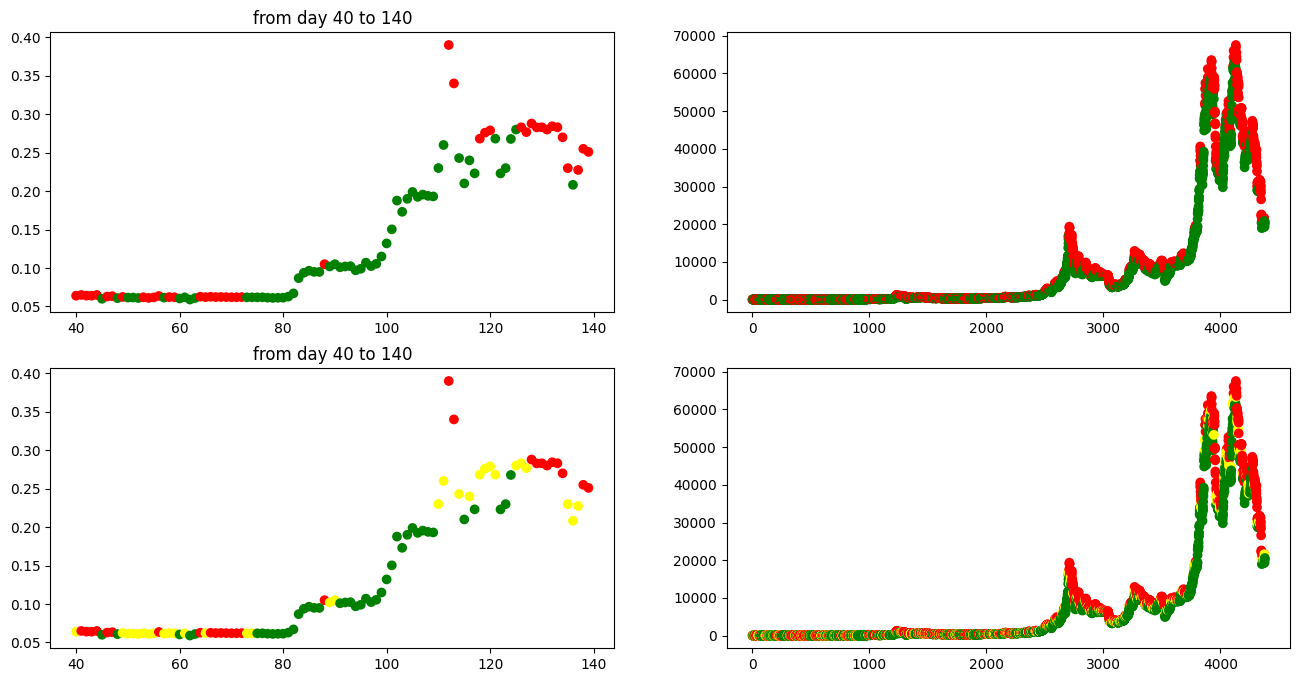

In [90]:
import matplotlib.pyplot as plt
import matplotlib

fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,8))

colors = ['red','yellow','green']
x = prices.index.tolist()
y = prices.close.values
label_2 = prices.y_classes_2.values
show_from = 40
show_to = 140#len(x)
axes[0][0].scatter(x[show_from:show_to], y[show_from:show_to], c=label_2[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))
axes[0][0].set_title(f'from day {show_from} to {show_to}')
axes[0][1].scatter(x, y, c=label_2, cmap=matplotlib.colors.ListedColormap(colors))

label_3 = prices.y_classes_3.values
axes[1][0].scatter(x[show_from:show_to], y[show_from:show_to], c=label_3[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))
axes[1][0].set_title(f'from day {show_from} to {show_to}')
axes[1][1].scatter(x, y, c=label_3, cmap=matplotlib.colors.ListedColormap(colors))


## normal regression targets (label is the slope of the regression)

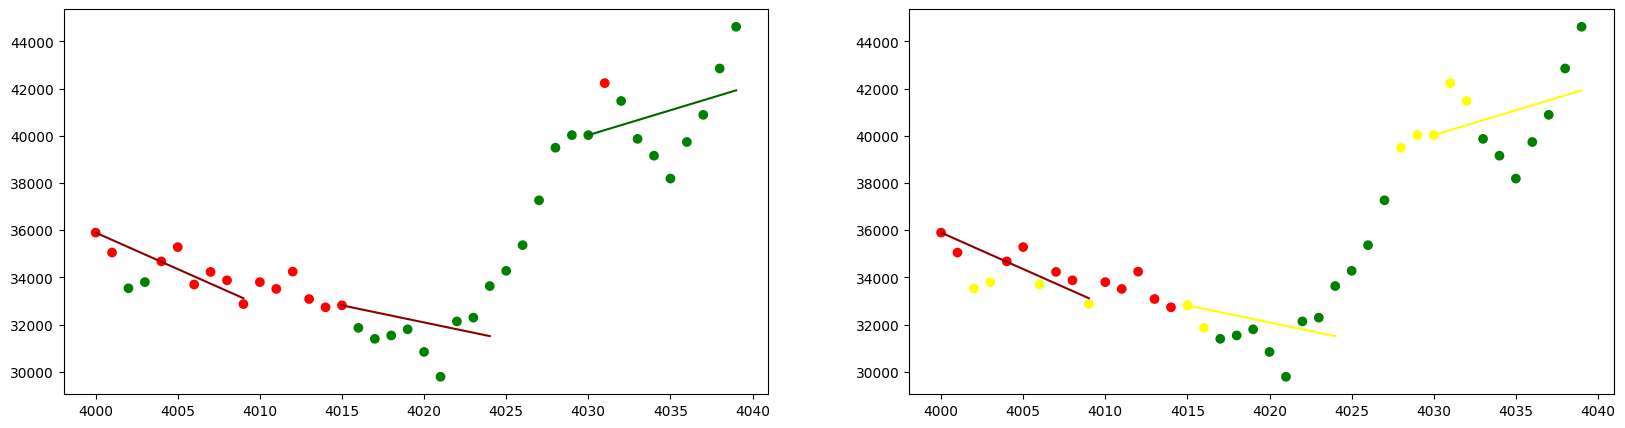

In [112]:
import numpy as np
import importlib
importlib.reload(_preprocessing)

regression_gen = _preprocessing.LinearCoefficientTargetGenerator(source_column_name='close',regression_for_days_ahead=10,result_column_name='y_regression')

prices = regression_gen.fit_transform(prices)

fig,axes = plt.subplots(ncols=2, figsize=(20,5))

colors = ['red','yellow','green']

x = prices.index.tolist()
y = prices.close.values
label_2 = prices.y_classes_2.values
label_3 = prices.y_classes_3.values
show_from = 4000
show_to = 4040
axes[0].scatter(x[show_from:show_to], y[show_from:show_to], c=label_2[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))
axes[1].scatter(x[show_from:show_to], y[show_from:show_to], c=label_3[show_from:show_to], cmap=matplotlib.colors.ListedColormap(colors))

line_at_every = 15

line_starts_values = prices.close.values[show_from::line_at_every]
line_slopes_values = prices.y_regression.values[show_from::line_at_every]

lines = []
line_length = 10

for line_start_idx in np.arange(show_from,show_to,15):

    x_values = np.arange(line_start_idx,line_start_idx+line_length,1)

    segment = prices.close.iloc[line_start_idx:line_start_idx+line_length]
    slope = prices.y_regression.iloc[line_start_idx] * np.std(segment)
    y_values = np.array([ prices.close.iloc[line_start_idx] + slope * step
                          for step in range(line_length)])

    color_2 = 'darkred' if prices.y_regression.iloc[line_start_idx] < 0 else 'darkgreen'
    axes[0].plot(x_values, y_values, c = color_2)

    color_3 = 'darkred' if prices.y_regression.iloc[line_start_idx] < -0.15 \
        else 'darkgreen' if prices.y_regression.iloc[line_start_idx] > 0.15 \
        else 'yellow'
    axes[1].plot(x_values, y_values, c = color_3)

#### Distributions

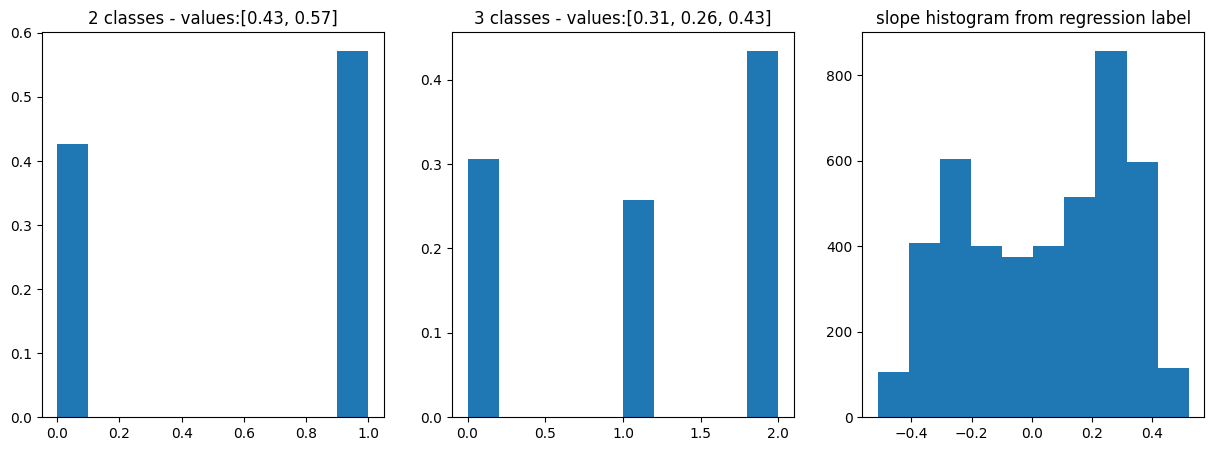

In [133]:
from matplotlib.ticker import PercentFormatter
fig,axes=plt.subplots(ncols=3,figsize=(15,5))

counts, edges, bars = axes[0].hist(prices.y_classes_2, weights=np.ones(len(prices)) / len(prices))
values = []
for bar in bars:
    if bar.get_height() != 0:
        values.append(round(bar.get_height(),2))
axes[0].set_title('2 classes - values:' + str(values))

counts, edges, bars = axes[1].hist(prices.y_classes_3, weights=np.ones(len(prices)) / len(prices))
values = []
for bar in bars:
    if bar.get_height() != 0:
        values.append(round(bar.get_height(),2))
axes[1].set_title('3 classes - values:' + str(values))

axes[2].hist(prices.y_regression)
axes[2].set_title('slope histogram from regression label');

### last value and random predictor

In [134]:
prices.head(3)

,close,close_pct_changes,debug,y_classes_2,y_classes_3,y_regression
0,0.04951,NaN,NaN,1.0,1.0,0.123990
1,0.08584,73.379115,NaN,0.0,0.0,-0.333851
2,0.08080,-5.871389,NaN,0.0,0.0,-0.331022


In [137]:
#for two classes
from models.baselines import LastValuePredictor
reshaped =np.reshape(prices.values,(len(prices),-1,prices.shape[-1]))
predictor_last_value_2_classes = LastValuePredictor(predict_feature_idx=3)
y_preds_lv_2_classes = predictor_last_value_2_classes.predict(reshaped).reshape(-1)
predictables_lv = prices.iloc[1:]
success = len(predictables_lv[predictables_lv.y_classes_2 == y_preds_lv_2_classes[:-1]])
success / len(predictables_lv)

0.8484848484848485

In [138]:
#for 3 classes
from models.baselines import LastValuePredictor
reshaped =np.reshape(prices.values,(len(prices),-1,prices.shape[-1]))
predictor_last_value_3_classes = LastValuePredictor(predict_feature_idx=4)
y_preds_lv_3_classes = predictor_last_value_3_classes.predict(reshaped).reshape(-1)
predictables_lv = prices.iloc[1:]
success = len(predictables_lv[predictables_lv.y_classes_3 == y_preds_lv_3_classes[:-1]])
success / len(predictables_lv)

0.7245386192754614

In [144]:
#2 classes random with matching distribution
import models
import importlib
importlib.reload(models.baselines)
prices_notna = prices.iloc[1:-10]
reshaped_notna=np.reshape(prices_notna.values,(len(prices_notna),-1,prices_notna.shape[-1]))
random_predictor = models.baselines.RandomBinaryPredictor(predict_feature_idx=3,match_distribution=True)
y_preds_binary = random_predictor.predict(reshaped_notna)
predictables_binary = prices_notna
success_binary = len(predictables_binary[predictables_binary.y_classes_2 ==y_preds_binary])
success_binary / len(predictables_binary)

0.5044530714775063